In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.datasets import load_breast_cancer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score, mean_absolute_percentage_error

# import graphviz
# from sklearn.tree import export_graphviz
import time

import xgboost
import pickle

In [2]:
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
mpl.style.use("default")
mpl.rcParams.update({"figure.constrained_layout.use": True})

sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

In [3]:
# data_prep 에서 train/test split한 pivot table

train_scaled = pd.read_csv("./knn_train_scaled.csv",index_col=0)
test_scaled = pd.read_csv("./knn_test_scaled.csv",index_col=0)

train = pd.read_csv("./train_orig.csv",index_col=0)
test = pd.read_csv("./test_orig.csv",index_col=0)

In [4]:
#load lists
import pickle

dir = './features/'
with open(dir+'avoid_list_orig.pickle','rb') as f:
    avoid_list_orig = pickle.load(f)
with open(dir+'city_info.pickle','rb') as f:
    city_info = pickle.load(f)
with open(dir+'strata_info.pickle','rb') as f:
    strata_info = pickle.load(f)
with open(dir+'heuristic_list.pickle','rb') as f:
    heuristic_list = pickle.load(f)
with open(dir+'target_cand.pickle','rb') as f:
    target_cand = pickle.load(f)
with open(dir+'targetspecific_list.pickle','rb') as f:
    targetspecific_list = pickle.load(f)

target_list = target_cand

In [5]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_xgb(prediction,answer):
    test_mse = mean_squared_error(answer, prediction)
    test_rmse = np.sqrt(test_mse)
    test_mape = mean_absolute_percentage_error(prediction,answer)
    test_r2 = r2_score(answer, prediction)

    return {'mse': test_mse, 'mape': test_mape, 'rmse': test_rmse, 'r2': test_r2}

In [6]:
fill_na = False
batch_size = 32
n_epoch = 100

In [7]:
def train_eval(target_list,heuristic,lr=1e-3,n_estimator=300,max_depth=None,save_path='results/mlp/result.pkl'):
    
    result_dict = dict()
    for target in target_list:

        print(f'target: {target}')
        avoid_list = avoid_list_orig
        avoid_list += targetspecific_list[target]

        print(f'target: {target}')
        avoid_list = avoid_list_orig
        avoid_list += targetspecific_list[target]

        if heuristic:
            x_train = train_scaled.loc[train[train[target].notna()].index,train_scaled.columns.isin(strata_info) | (train_scaled.columns.isin(heuristic_list[target]) & ~(train_scaled.columns.isin(avoid_list)))]#features_list]
            y_train = train[train[target].notna()][target]

            # x_val = val_scaled.loc[:,val_scaled.columns.isin(heuristic_list[target]) & ~(val_scaled.columns.isin(avoid_list))]#features_list]
            # y_val = val[target]

            x_test = test_scaled.loc[test[test[target].notna()].index,test_scaled.columns.isin(strata_info) | (test_scaled.columns.isin(heuristic_list[target]) & ~(test_scaled.columns.isin(avoid_list)))]#features_list]
            y_test = test[test[target].notna()][target]
        else:
            x_train = train_scaled.loc[train[train[target].notna()].index,train_scaled.columns.isin(strata_info) | ~(train_scaled.columns.isin(avoid_list) | train_scaled.columns.isin(target_cand) | train_scaled.columns.isin(city_info))]#features_list]
            y_train = train[train[target].notna()][target]

            # x_val = val_scaled.loc[:,~(val_scaled.columns.isin(avoid_list) | val_scaled.columns.isin(target_cand) | val_scaled.columns.isin(city_info))]#features_list]
            # y_val = val[target]

            x_test = test_scaled.loc[test[test[target].notna()].index,test_scaled.columns.isin(strata_info) | ~(test_scaled.columns.isin(avoid_list) | test_scaled.columns.isin(target_cand) | test_scaled.columns.isin(city_info))]#features_list]
            y_test = test[test[target].notna()][target]

        if fill_na:
            for col in x_train.columns:
                x_train[col] = x_train[col].fillna(x_train[col].median())
                # x_val[col] = x_val[col].fillna(x_train[col].median())
                x_test[col] = x_test[col].fillna(x_train[col].median())

        #XGB Regressor

        cities_xgb = xgboost.XGBRegressor(booster = "gbtree", 
                         learning_rate = lr, 
                         max_depth = 5,
                         n_estimators = n_estimator,
                         random_state=42)
        cities_xgb.fit(x_train,y_train.values.ravel())

        cities_pred_train = cities_xgb.predict(x_train)
        cities_pred_test = cities_xgb.predict(x_test)

        train_result = evaluate_xgb(cities_pred_train,y_train)
        eval_result = evaluate_xgb(cities_pred_test,y_test)

        result_dict[target] = {'train': train_result, 'test': eval_result, 'feature_importance': cities_xgb.feature_importances_}

        with open(path,'wb') as fw:
            pickle.dump(result_dict, fw)
    return result_dict
# print('train mse: ' ,metrics.mean_squared_error(cities_pred_train,y_train))
# print('test mse: ' ,metrics.mean_squared_error(cities_pred_test,y_test))

# print('train r2: ' ,metrics.r2_score(cities_pred_train,y_train))
# print('test r2: ' ,metrics.r2_score(cities_pred_test,y_test))

In [8]:
result_combined = dict()
for lr in [1e-1,5e-2,1e-2]:
    for n_estimator in [100,300,500]:
        for h in [True,False]:
            path = f'results/xgb/result_xgb_{lr}_{n_estimator}_h.pickle' if h else f'results/rf/result_rf_{lr}_{n_estimator}.pickle'
            if lr not in result_combined.keys():
                result_combined[lr] = dict()
            if n_estimator not in result_combined[lr].keys():
                result_combined[lr][n_estimator] = dict()
        
            result_combined[lr][n_estimator][h] = train_eval(target_list,heuristic=h,lr=lr,n_estimator=n_estimator,save_path=path)

# x_train = x_train.apply(lambda x: x.fillna(x.median()),axis=0)

# x_test = x_test.apply(lambda x: x.fillna(x.median()),axis=0)

# msno.matrix(x_train)

target: Cancer | All Cancer Deaths
target: Cancer | All Cancer Deaths
target: Cancer | Colorectal Cancer Deaths
target: Cancer | Colorectal Cancer Deaths
target: Cancer | Lung Cancer Deaths
target: Cancer | Lung Cancer Deaths
target: Cardiovascular Disease | Cardiovascular Disease Deaths
target: Cardiovascular Disease | Cardiovascular Disease Deaths
target: Cardiovascular Disease | Heart Disease Deaths
target: Cardiovascular Disease | Heart Disease Deaths
target: Deaths | Deaths from All Causes
target: Deaths | Deaths from All Causes
target: Deaths | Gun Deaths (Firearms)
target: Deaths | Gun Deaths (Firearms)
target: Deaths | Injury Deaths
target: Deaths | Injury Deaths
target: Deaths | Motor Vehicle Deaths
target: Deaths | Motor Vehicle Deaths
target: Deaths | Premature Death
target: Deaths | Premature Death
target: Diabetes and Obesity | Diabetes Deaths
target: Diabetes and Obesity | Diabetes Deaths
target: Life Expectancy at Birth | Life Expectancy
target: Life Expectancy at Birth 

In [ ]:
with open('results/xgb/xgb.pickle','wb') as fw:
        pickle.dump(result_combined, fw)

In [ ]:
def flatten_dict(nested_dict):
    res = {}
    if isinstance(nested_dict, dict):
        for k in nested_dict:
            flattened_dict = flatten_dict(nested_dict[k])
            for key, val in flattened_dict.items():
                key = list(key)
                key.insert(0, k)
                res[tuple(key)] = val
    else:
        res[()] = nested_dict
    return res


def nested_dict_to_df(values_dict):
    flat_dict = flatten_dict(values_dict)
    df = pd.DataFrame.from_dict(flat_dict, orient="index")
    df.index = pd.MultiIndex.from_tuples(df.index)
    df = df.unstack(level=-1)
    df.columns = df.columns.map("{0[1]}".format)
    return df

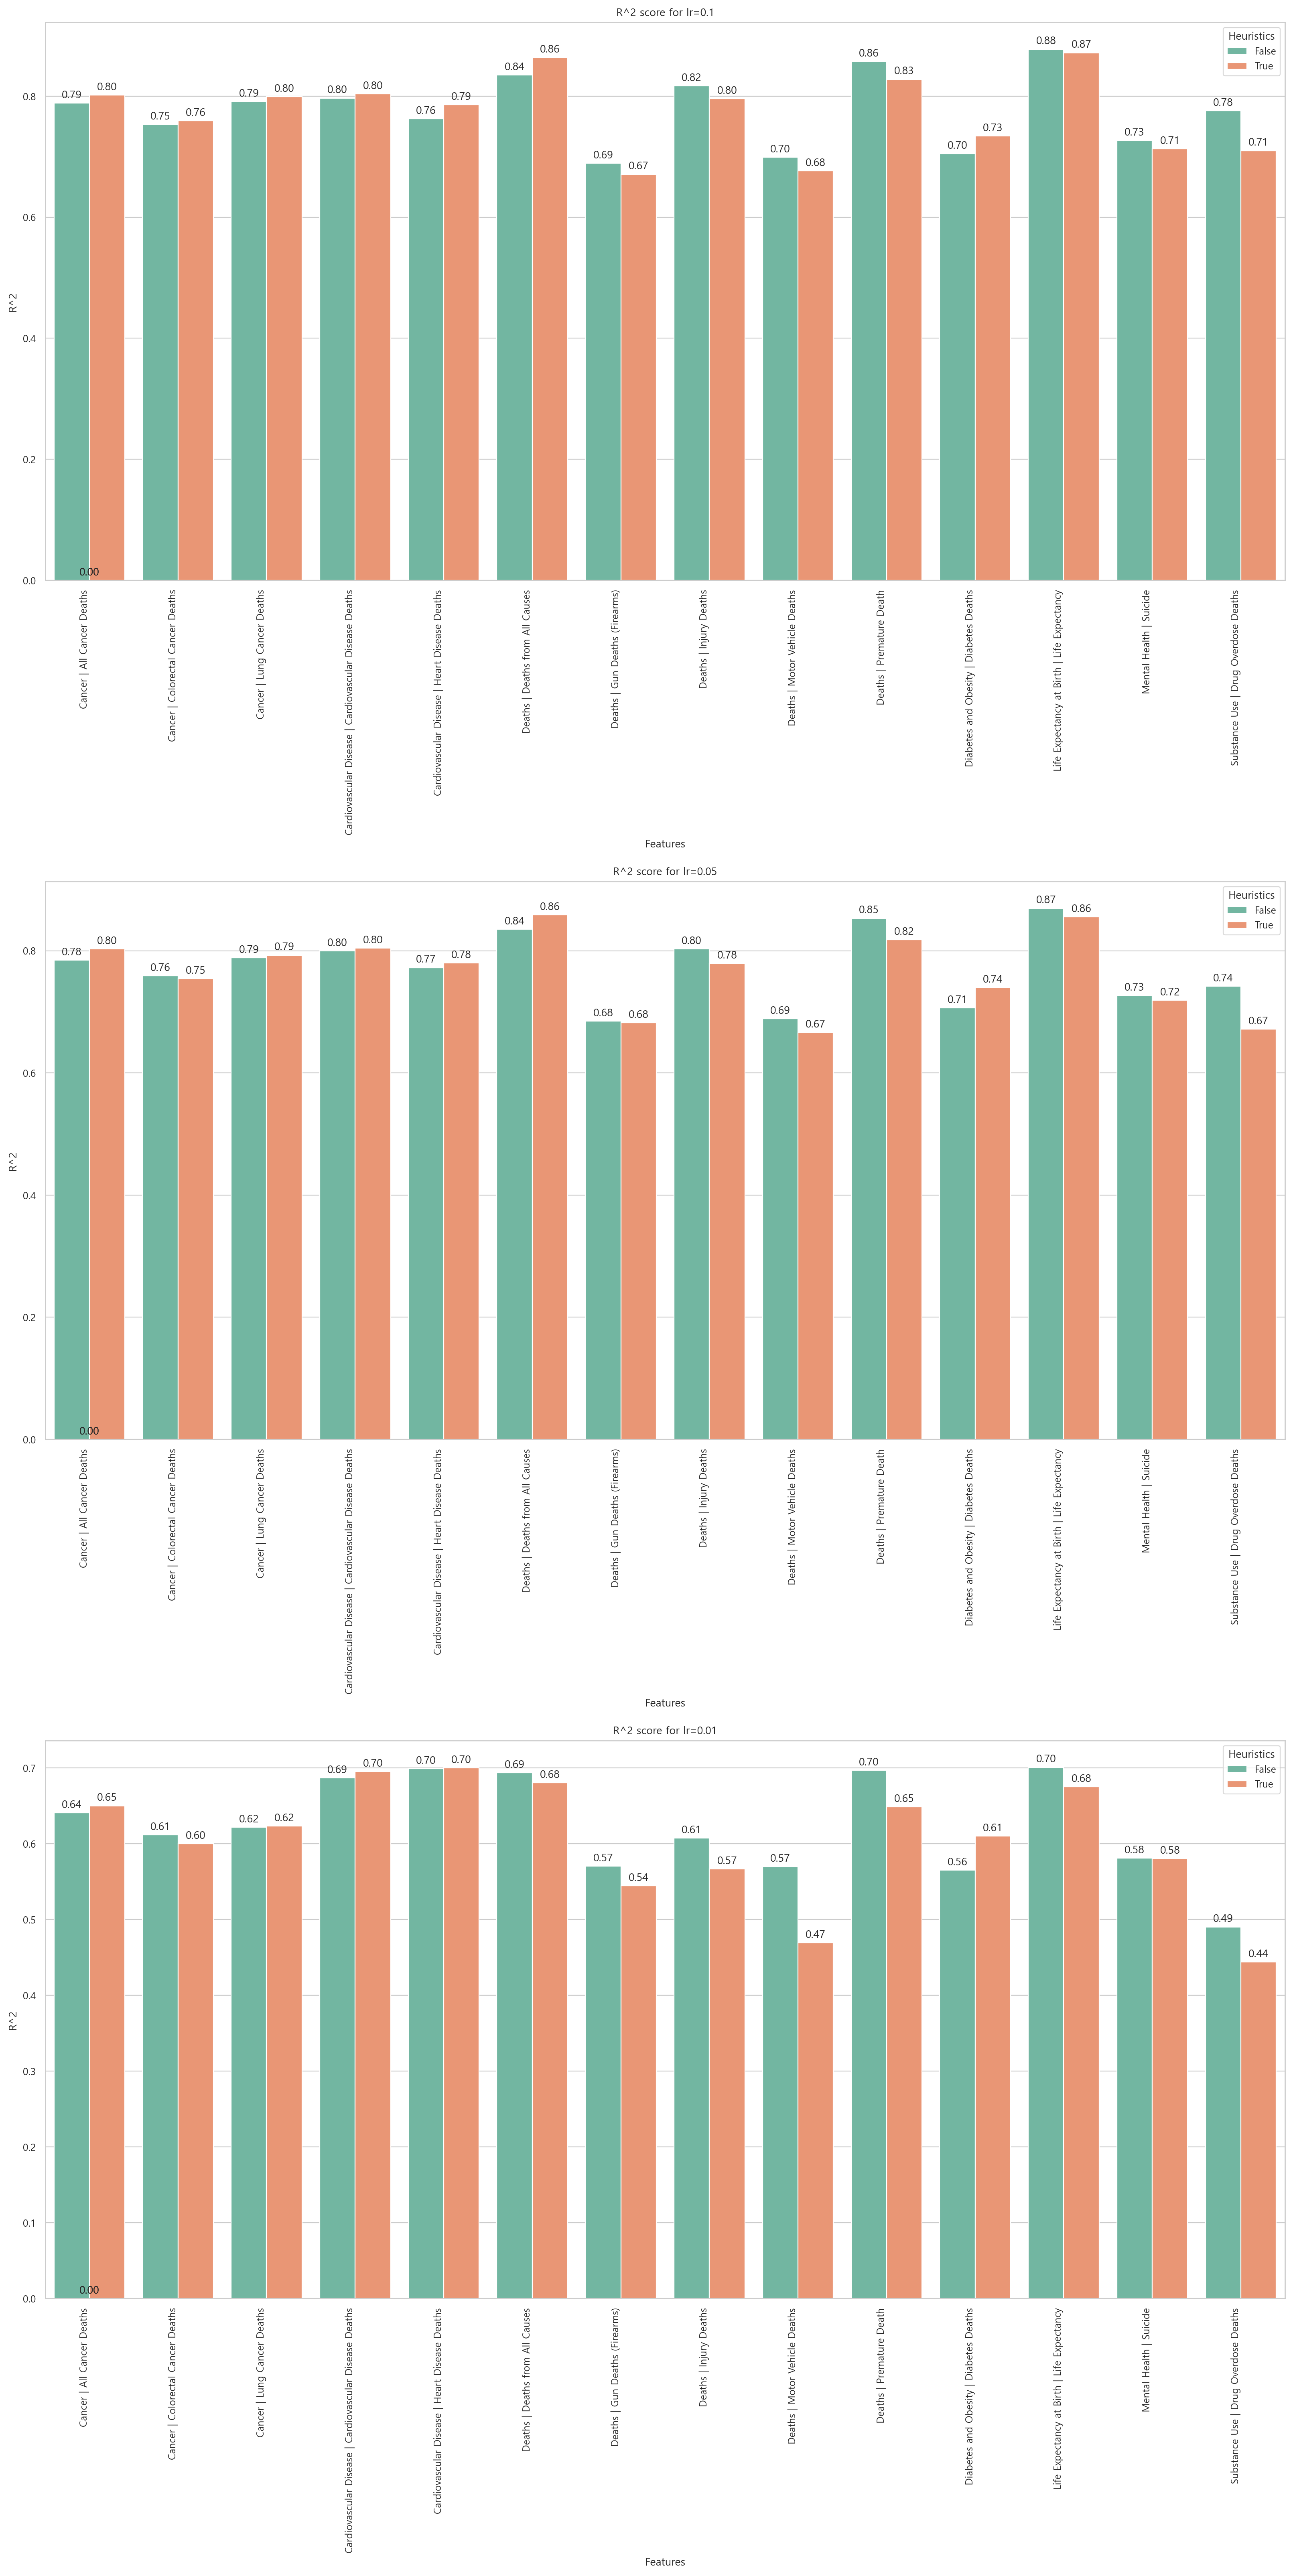

In [ ]:
import seaborn as sns
import copy
fig ,axes = plt.subplots(3,1,figsize=(16,32))



for idx, key in enumerate(result_combined.keys()):
    data_dict = copy.deepcopy(result_combined[key])
    # print(data_dict)
    for val in data_dict.values():
        for val2 in val.values():
            for val3 in val2.values():
                del val3["feature_importance"]


    df_dict = nested_dict_to_df(data_dict).reset_index()

    df_dict = df_dict.rename(columns={"level_0": "Estimators", "level_1": "Heuristics","level_3": "mode"})

    df_dict = df_dict[(df_dict["mode"] == "test") & (df_dict["Estimators"] == 100)]


    # pd.DataFrame.from_dict()

    sns.barplot(data=df_dict,x='level_2', y='r2', hue = 'Heuristics', ax=axes[idx])
    axes[idx].set_xticks(axes[idx].get_xticks(), axes[idx].get_xticklabels(), rotation=90, ha='right')

    axes[idx].set(xlabel="Features",ylabel="R^2",title=f"R^2 score for lr={key}")

    for p in axes[idx].patches:
        axes[idx].annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext =(0, 7), textcoords='offset points')

plt.savefig('xgb_mape.png')

In [5]:
# cities_xgb = xgboost.XGBRegressor(booster = "gbtree", 
#                          learning_rate = 0.05, 
#                          max_depth = 5,
#                          n_estimators = 300)

# cities_xgb.fit(x_train,y_train.values.ravel())

# cities_pred_train = cities_xgb.predict(x_train)
# cities_pred_test = cities_xgb.predict(x_test)

# print('train mse: ' ,metrics.mean_squared_error(cities_pred_train,y_train))
# print('test mse: ' ,metrics.mean_squared_error(cities_pred_test,y_test))# 

train mse:  0.05347700406738481
test mse:  368.6859799062848


In [ ]:
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.

In [ ]:
# target = "Cancer | All Cancer Deaths"

n_est = 300

fig ,axes = plt.subplots(len(result_combined[n_est][True].keys()), 2, figsize=(30,120))

for i, h in enumerate(result_combined[n_est].keys()):
    for j, target in enumerate(result_combined[n_est][h].keys()):

        importance = result_combined[300][False][target]["feature_importance"]
        # ['feature_importance']
        # std = np.std([tree.feature_importances_ for tree in cities_rfc.estimators_], axis=0)
        avoid_list = avoid_list_orig
        if h:
            x_train = train_scaled.loc[train[train[target].notna()].index,train_scaled.columns.isin(strata_info) | (train_scaled.columns.isin(heuristic_list[target]) & ~(train_scaled.columns.isin(avoid_list)))]
        else:
            x_train = train_scaled.loc[train[train[target].notna()].index,train_scaled.columns.isin(strata_info) | ~(train_scaled.columns.isin(avoid_list) | train_scaled.columns.isin(target_cand) | train_scaled.columns.isin(city_info))]
        forest_importance = pd.Series(importance, index=x_train.columns)

        ax = axes[j][i]
        forest_importance.plot.bar(ax=ax)

        heuristics = "H" if h else ""
        ax.set(xlabel="Features",ylabel="Feature Importance",title=f"{target} {heuristics}")
        add_value_labels(ax)
plt.savefig("rf_featureimportance.png")

<Axes: >

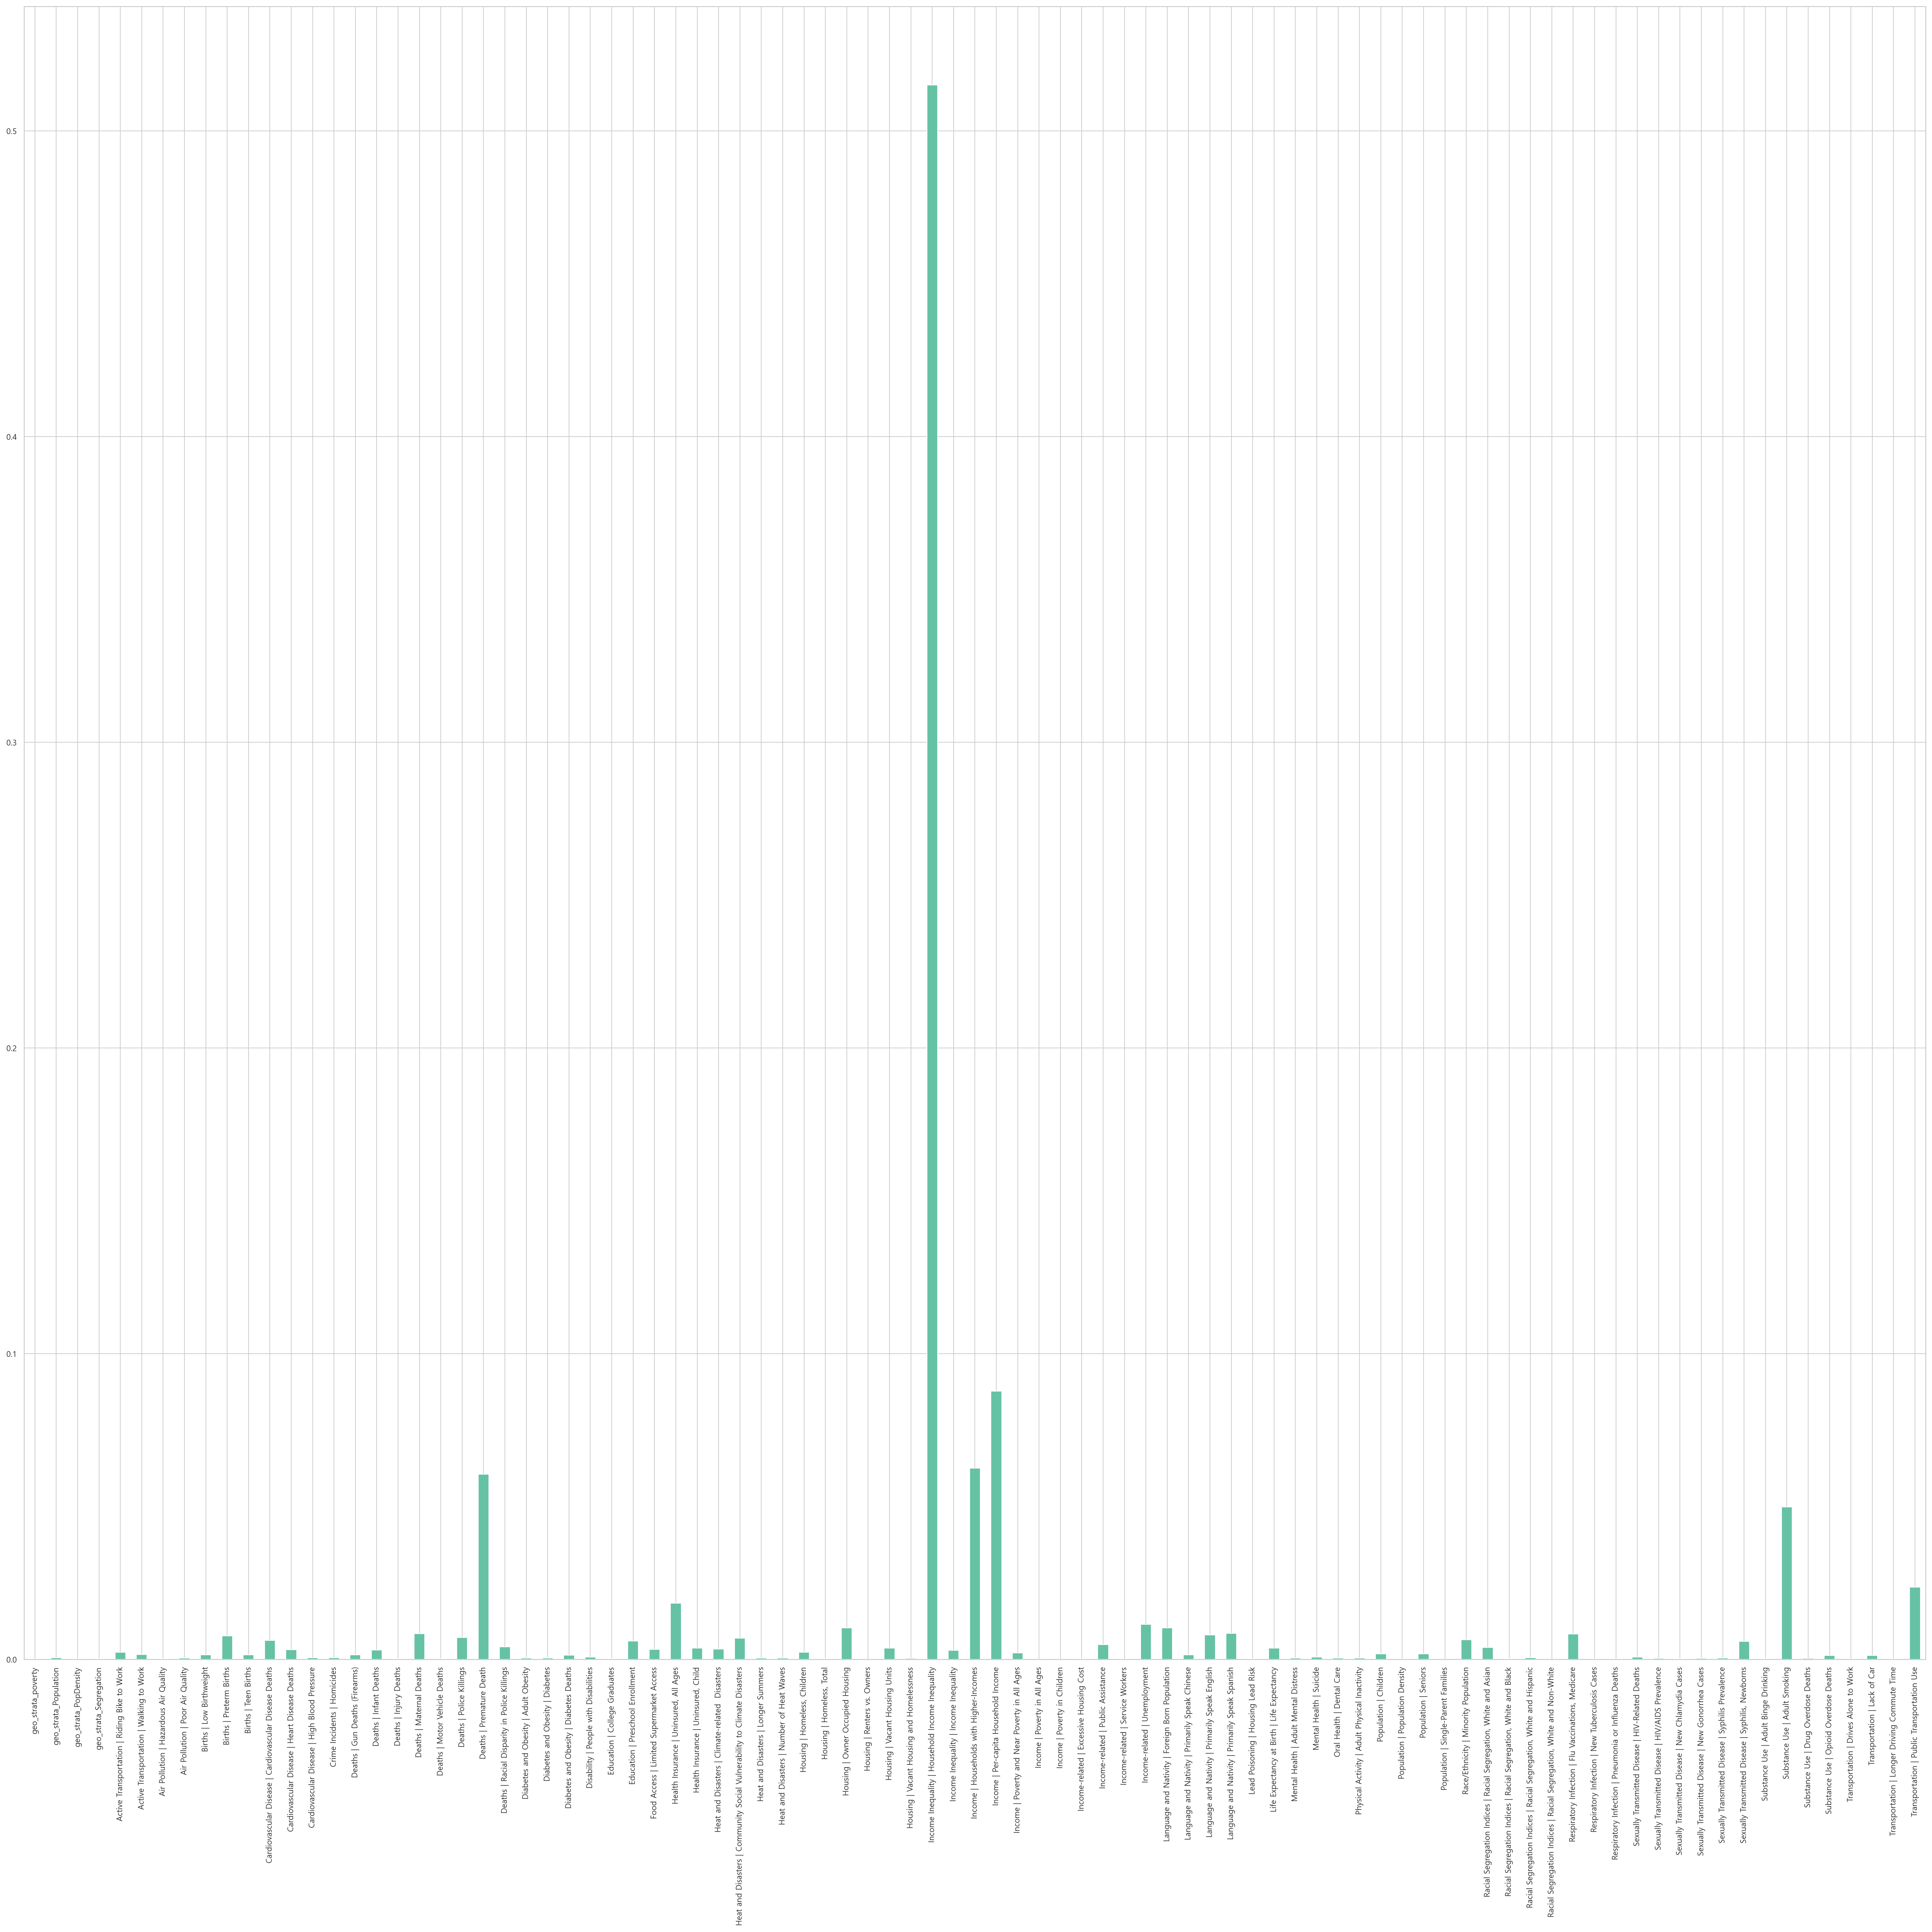

In [6]:
#feature importance 계산
importance = cities_xgb.feature_importances_

xgb_importance = pd.Series(importance, index=x_train.columns)

fig ,ax = plt.subplots(figsize=(30,30))
xgb_importance.plot.bar(ax=ax)

In [7]:
def threshold(p):
    return np.quantile(xgb_importance,p).item()

In [8]:
df_importance = xgb_importance.to_frame()

#95%
display(df_importance[df_importance[0] > threshold(0.95)])
#90%
display(df_importance[df_importance[0] > threshold(0.9)])
#10%
display(df_importance[df_importance[0] < threshold(0.1)])
#5%
display(df_importance[df_importance[0] < threshold(0.05)])

,0
Deaths | Premature Death,0.060507
Income Inequality | Household Income Inequality,0.515040
Income | Households with Higher-Incomes,0.062537
Income | Per-capita Household Income,0.087681
Substance Use | Adult Smoking,0.049765


,0
Deaths | Premature Death,0.060507
"Health Insurance | Uninsured, All Ages",0.018373
Housing | Owner Occupied Housing,0.010266
Income Inequality | Household Income Inequality,0.515040
Income | Households with Higher-Incomes,0.062537
Income | Per-capita Household Income,0.087681
Income-related | Unemployment,0.011402
Substance Use | Adult Smoking,0.049765
Transportation | Public Transportation Use,0.023609


,0
geo_strata_poverty,0.000023
geo_strata_PopDensity,0.000030
Housing | Renters vs. Owners,0.000000
Income | Poverty in Children,0.000016
Income-related | Excessive Housing Cost,0.000038
Income-related | Service Workers,0.000049
Population | Single-Parent Families,0.000000
"Racial Segregation Indices | Racial Segregation, White and Non-White",0.000018
Transportation | Drives Alone to Work,0.000057


,0
geo_strata_poverty,0.000023
Housing | Renters vs. Owners,0.000000
Income | Poverty in Children,0.000016
Population | Single-Parent Families,0.000000
"Racial Segregation Indices | Racial Segregation, White and Non-White",0.000018
